In [1]:
import torchvision                                        #! pip3 install torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
trainset = MNIST(root = './', train=True, download=True, transform=transform)
testset = MNIST(root = './', train=False, download=True, transform=transform)

Number of observations in train set: 60000
 Number of observations in test set: 10000


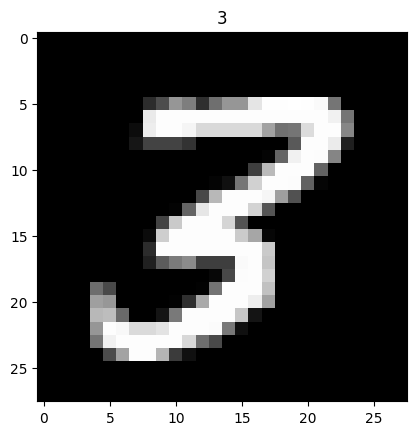

In [2]:
print(f"Number of observations in train set: {trainset.data.shape[0]}")
print(f" Number of observations in test set: {testset.data.shape[0]}")

# plotting an image in the dataset using imshow()
idx = 2489
plt.imshow(trainset.data[idx], cmap='gray')
plt.title(trainset.targets[idx].item())
plt.show()

# Binary

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

# sample size and features to work with
s = 10                                                                   # reduced features to work with 
sFeatures = np.random.choice(np.arange(784), size=s, replace=False)       # choose s features randomly from the 784
sFeatures.sort()
nSample = 1000

# choose two class labels
class1Label = 4
class2Label = 9

class1Images = trainset.data[trainset.targets==class1Label].reshape(-1,784).numpy()      # images with class1
class2Images = trainset.data[trainset.targets==class2Label].reshape(-1,784).numpy()      # images with class2

# work with a smaller sample size
class1Images = class1Images[:nSample, sFeatures]
class2Images = class2Images[:nSample, sFeatures]
X = np.concatenate((class1Images, class2Images), axis=0)
y = np.concatenate((np.zeros(class1Images.shape[0]), np.ones(class2Images.shape[0])))

# create Xtrain, Xvalid, Xtest
Xtrain, X_, ytrain, y_ = train_test_split(X, y, test_size=0.4, shuffle=True)
Xvalid, Xtest, yvalid, ytest = train_test_split(X_, y_, test_size=0.5, shuffle=True)

print(f'Xtrain shape = {Xtrain.shape}')
print(f'Xvalid shape = {Xvalid.shape}')
print(f'Xtest  shape = {Xtest.shape}')

Xtrain shape = (1200, 10)
Xvalid shape = (400, 10)
Xtest  shape = (400, 10)


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

binary_classes = [0, 1]

# Filter training data
train_mask = np.isin(ytrain, binary_classes)
Xtrain_bin = Xtrain[train_mask]
ytrain_bin = ytrain[train_mask]

# Filter test data
test_mask = np.isin(ytest, binary_classes)
Xtest_bin = Xtest[test_mask]
ytest_bin = ytest[test_mask]

# Filter validation data
valid_mask = np.isin(yvalid, binary_classes)
Xvalid_bin = Xvalid[valid_mask]
yvalid_bin = yvalid[valid_mask]

C_grid = np.linspace(0.0001, 0.2, 100)

# Use correct param name for nested estimator
param_grid = {'estimator__C': C_grid}

grid_lr = GridSearchCV(
    estimator=OneVsRestClassifier(LogisticRegression(penalty='l1', solver='liblinear')),
    cv=10,
    param_grid=param_grid,
    scoring='neg_log_loss'
)
grid_lr.fit(Xvalid_bin, yvalid_bin)
Cbest = grid_lr.best_params_['estimator__C']
print(f'Best C according to gridsearch: {Cbest}')

# Train final model
logistic_mod = OneVsRestClassifier(
    LogisticRegression(penalty='l1', solver='liblinear', C=Cbest)
).fit(Xtrain_bin, ytrain_bin)

print(f'Train Accuracy: {accuracy_score(logistic_mod.predict(Xtrain_bin), ytrain_bin)}')
print(f'Test Accuracy: {accuracy_score(logistic_mod.predict(Xtest_bin), ytest_bin)}')


Best C according to gridsearch: 0.002119191919191919
Train Accuracy: 0.48583333333333334
Test Accuracy: 0.5075


# Metrics

## TPR, TNR
- True Positive Rate (TPR), Sensitivity, Recall: $\text{TPR} = \frac{\text{TP}}{\text{P}} = \frac{\text{TP}}{\text{TP} + \text{FN}}$ where $P$ is the actual number of positive values in the data.
- True Negative Rate (TNR), Specificity, Selectivity: $\text{TNR} = \frac{\text{TN}}{\text{N}} = \frac{\text{TN}}{\text{TN} + \text{FP}}$ where $N$ is the actual number of negative values in the data.

Any good classifier should ideally have a large TPR and a large TNR, but there is a trade-off between the two.

## ROC
Receiver Operator Characteristic (ROC) curve is a graphical depiction of what happens to the TPR and FPR = 1-TNR as we vary the threshold $t$. It is a good way of comparing different classification models. 

## AUC
The Area Under the Curve (AUC) gives us a nice summary of how good a particular model is, it is the area under each of the ROC curves.

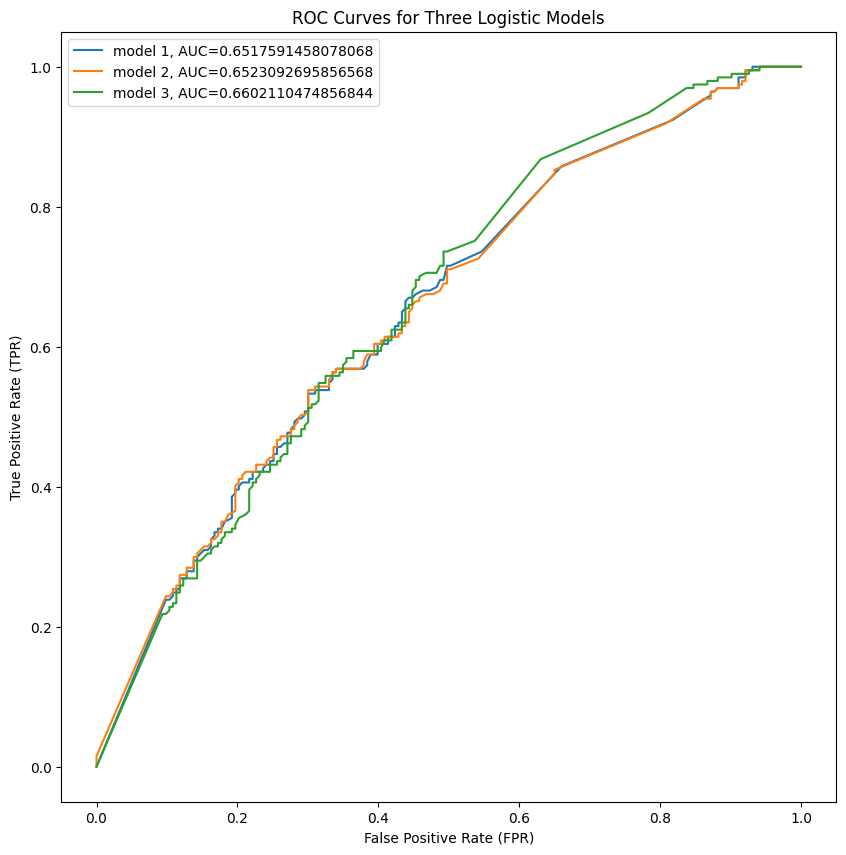

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

# choosing C via cross validation then computing FPR and TPR at all thresholds
logistic_mod_1 = OneVsRestClassifier(LogisticRegression( penalty='l1',  solver='liblinear', C=Cbest)).fit(Xtrain, ytrain)
mod_1_preds = logistic_mod_1.predict_proba(Xtest)[:,1]        # note, predictions need to be just for one of the classes
fpr_1, tpr_1, _ = roc_curve(ytest, mod_1_preds)
auc_1 = roc_auc_score(ytest, mod_1_preds)

# choosing C small
logistic_mod_2 = OneVsRestClassifier(LogisticRegression(penalty='l1', solver='liblinear', C=0.02)).fit(Xtrain, ytrain)
mod_2_preds = logistic_mod_2.predict_proba(Xtest)[:,1]
fpr_2, tpr_2, _ = roc_curve(ytest, mod_2_preds)
auc_2 = roc_auc_score(ytest, mod_2_preds)

# choosing C to be very large (no regularization)
logistic_mod_3 = OneVsRestClassifier(LogisticRegression(solver='liblinear', C=1000)).fit(Xtrain, ytrain)
mod_3_preds = logistic_mod_3.predict_proba(Xtest)[:,1]
fpr_3, tpr_3, _ = roc_curve(ytest, mod_3_preds)
auc_3 = roc_auc_score(ytest, mod_3_preds)


fig = plt.figure(figsize=(10,10))
plt.plot(fpr_1, tpr_1, label="model 1, AUC="+str(auc_1))
plt.plot(fpr_2, tpr_2, label="model 2, AUC="+str(auc_2))
plt.plot(fpr_3, tpr_3, label="model 3, AUC="+str(auc_3))
plt.ylabel("True Positive Rate (TPR)")
plt.xlabel("False Positive Rate (FPR)")
plt.title("ROC Curves for Three Logistic Models")
plt.legend()
plt.show()


# Multiclass

In [14]:
# subsample the data to make it more manageable
nSample = 2000
idxsTrain = np.random.choice(np.arange(trainset.data.shape[0]), size=nSample, replace=False)
idxsTest = np.random.choice(np.arange(testset.data.shape[0]), size=nSample//5, replace=False)

Xtrain = trainset.data.reshape(-1, 784).numpy()[idxsTrain, :]
Xtest = testset.data.reshape(-1, 784).numpy()[idxsTest, :]            
ytrain = trainset.targets.numpy()[idxsTrain]
ytest = testset.targets.numpy()[idxsTest]

print(f'Xtrain shape = {Xtrain.shape}')
print(f'Xtest  shape = {Xtest.shape}')

Xtrain shape = (2000, 784)
Xtest  shape = (400, 784)


In [15]:
from sklearn.metrics import confusion_matrix

sm_mod = LogisticRegression(#automatically uses `multi_class = 'multinomial'` after scikit v1.5
                            penalty='l2',
                            C=50,
                            solver='sag',
                            tol=.001,
                            max_iter=1000
                            ).fit(Xtrain, ytrain)

ypred = sm_mod.predict(Xtest)
print("Confusion_matrix: \n"+str(confusion_matrix(ytest, ypred)))

Confusion_matrix: 
[[30  0  0  0  0  0  1  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 41  1  1  1  0  0  0  0]
 [ 0  1  0 39  0  1  0  1  2  1]
 [ 0  0  1  0 35  0  2  0  2  3]
 [ 1  0  0  5  2 28  0  0  2  0]
 [ 1  0  3  0  1  2 41  0  0  0]
 [ 0  2  1  1  0  0  0 32  0  2]
 [ 0  1  0  3  2  2  2  0 32  2]
 [ 0  0  1  1  3  1  0  1  1 24]]


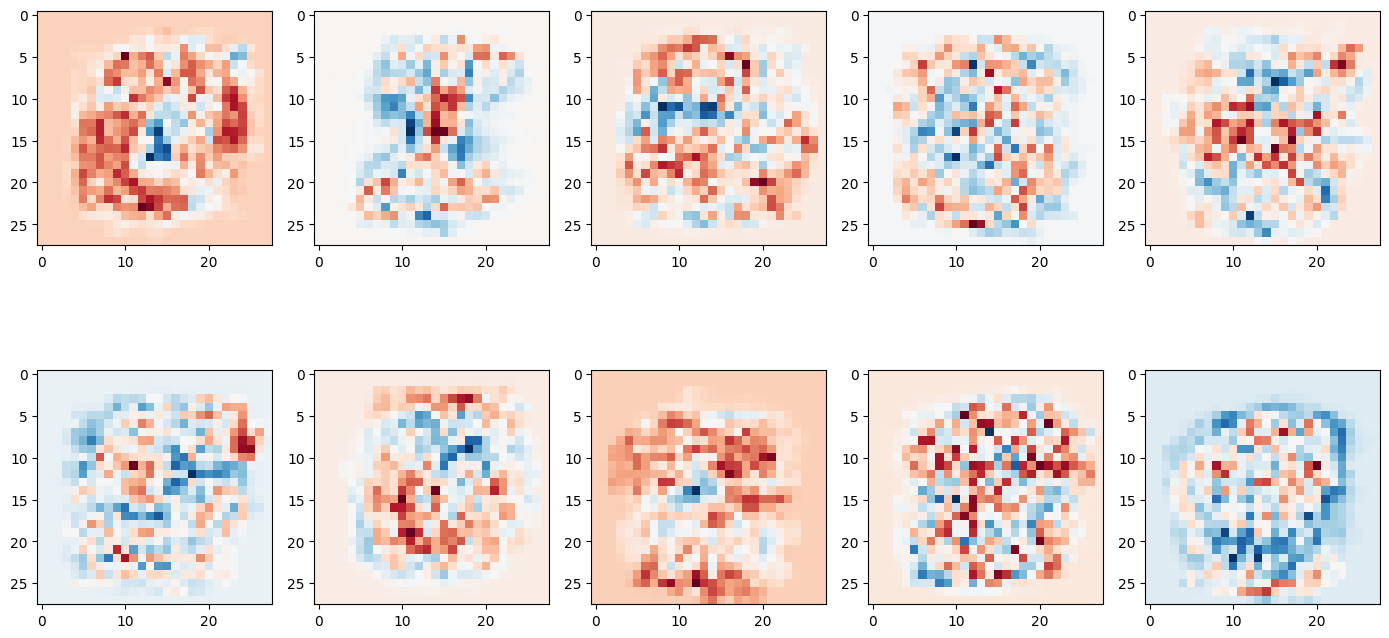

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(14,8))
for i, ax in enumerate(axes.flat):
    ax.imshow(sm_mod.coef_[i].reshape(28,28), cmap=plt.cm.RdBu_r, interpolation='nearest')
plt.tight_layout()
plt.show()